# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

<b>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
</b>

<h1>1 Introduction : </h1>

Dans ce projet nous allons analyser des données décrivant des films. Les problématiques traitées sont :
<ul>
    <li>Clustering des acteurs selon le genre des films dans lesquels ils tournent.</li>
    <li>Clustering des acteurs selon la qualité des films dans lesquels ils tournent.</li>
    <li>La prédiction de la note moyenne donnée à un film par les internautes</li>
    <li>La prédiction de la popularité d'un film</li>
    <li>Classification des films selon la note moyenne donnée à un film par les internautes</li>
</ul>

<h1>2 Chargement et Analyse des Donnees : </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import math
import seaborn as sns
import copy

In [2]:
%load_ext autoreload
%autoreload 2

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation des algorithmes de clustering
from iads import kmoyennes as km

#importation des index de dunn et de de xb
from iads import Clustering_index as cli

#importation de la methode de bagging
from iads import bagging as bg

# importation de utils
from iads import utils as ut

<h2>2.1 Chargement des données -base MovieLens- </h2>

In [3]:
# Chargement des données MovieLens
fname_links = "./data/ml-20m/links.csv"
fname_movies = "./data/ml-20m/movies.csv"
fname_tags = "./data/ml-20m/tags.csv"
fname_ratings = "./data/ml-20m/ratings.csv"
links = pd.read_csv(fname_links, encoding='utf8')
links = links.dropna()
movies = pd.read_csv(fname_movies, encoding='utf8')
movies = movies.dropna()
tags = pd.read_csv(fname_tags, encoding='utf8', parse_dates=[-1])
tags = tags.dropna()
ratings = pd.read_csv(fname_ratings, encoding='utf8',chunksize=10000)

<b>Links</b>

In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<b>Movies</b>

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<b>Tags</b>

In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


<b> Ratings </b>

In [7]:
print(type(ratings))

<class 'pandas.io.parsers.TextFileReader'>


<h2>2.2 Chargement des données -Enrichissement- </h2>

In [8]:
# Chargement des données complémentaires
fname_actor = "./data/act_v2.pkl"
fname_crew = "./data/crew_v2.pkl"
fname_film = "./data/film_v2.pkl"
actor = pkl.load(open(fname_actor, "rb"))
crew = pkl.load(open(fname_crew, "rb"))
film = pkl.load(open(fname_film, "rb"))

<b>film : </b>il s'agit d'une liste de films, chaque films est un dictionnaire.

In [9]:
film[1:2]

[{'id': 8844,
  'video': False,
  'vote_count': 5594,
  'vote_average': 7.1,
  'title': 'Jumanji',
  'release_date': '1995-12-15',
  'original_language': 'en',
  'original_title': 'Jumanji',
  'genre_ids': [12, 14, 10751],
  'backdrop_path': '/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg',
  'adult': False,
  'overview': "When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",
  'poster_path': '/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg',
  'popularity': 2.947}]

In [10]:
# On cree un dataframe à partir de ce dictionnaire pour des utilisations futures
films = pd.DataFrame(film)
films.rename(columns={'id':'tmdbId'}, inplace=True)
films = films.dropna()
films.head()

,adult,backdrop_path,genre_ids,tmdbId,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",22.773,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,Toy Story,False,7.9,9550
1,False,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,2.947,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,1995-12-15,Jumanji,False,7.1,5594
2,False,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.076,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,Grumpier Old Men,False,6.5,140
3,False,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",2.917,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,1995-12-22,Waiting to Exhale,False,6.1,55
4,False,/cZs50rEk4T13qWedon0uCnbYQzW.jpg,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.817,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,Father of the Bride Part II,False,6.1,288


<b>actor : </b> il s'agit d'une liste de description des personnages des films, chaque description de personnages d'un film est une liste de dictionnaires, chaque dictionnaire représente un personnage du film.

In [11]:
actor[1:2]

[[{'cast_id': 1,
   'character': 'Alan Parrish',
   'credit_id': '52fe44bfc3a36847f80a7c73',
   'gender': 2,
   'id': 2157,
   'name': 'Robin Williams',
   'order': 0,
   'profile_path': '/3vypmub75rLItlC51uJUurNYkW0.jpg'},
  {'cast_id': 8,
   'character': 'Samuel Alan Parrish / Van Pelt',
   'credit_id': '52fe44bfc3a36847f80a7c99',
   'gender': 2,
   'id': 8537,
   'name': 'Jonathan Hyde',
   'order': 1,
   'profile_path': '/7il5D76vx6QVRVlpVvBPEC40MBi.jpg'},
  {'cast_id': 2,
   'character': 'Judy Shepherd',
   'credit_id': '52fe44bfc3a36847f80a7c77',
   'gender': 1,
   'id': 205,
   'name': 'Kirsten Dunst',
   'order': 2,
   'profile_path': '/5FBoENGAlSC69ZkW8KqsyUFCAYu.jpg'},
  {'cast_id': 24,
   'character': 'Peter Shepherd',
   'credit_id': '52fe44c0c3a36847f80a7ce7',
   'gender': 2,
   'id': 145151,
   'name': 'Bradley Pierce',
   'order': 3,
   'profile_path': '/j6iW0vVA23GQniAPSYI6mi4hiEW.jpg'},
  {'cast_id': 10,
   'character': 'Sarah Whittle',
   'credit_id': '52fe44bfc3a3684

In [12]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in actor:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...
# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

<b>crew : </b>il s'agit d'une liste de description du staff de films, chaque description d'un staff d'un film est une liste de dictionnaires, chaque dictionnaire represente un membre du staff.

In [13]:
crew[1:2]

[[{'credit_id': '52fe44bfc3a36847f80a7c7d',
   'department': 'Directing',
   'gender': 2,
   'id': 4945,
   'job': 'Director',
   'name': 'Joe Johnston',
   'profile_path': '/fbGZo6CG9Z9zKFh8D5wHunyu7gJ.jpg'},
  {'credit_id': '52fe44bfc3a36847f80a7c83',
   'department': 'Writing',
   'gender': 2,
   'id': 42356,
   'job': 'Novel',
   'name': 'Chris van Allsburg',
   'profile_path': None},
  {'credit_id': '52fe44bfc3a36847f80a7c89',
   'department': 'Writing',
   'gender': 2,
   'id': 876,
   'job': 'Screenplay',
   'name': 'Jonathan Hensleigh',
   'profile_path': '/l1c4UFD3g0HVWj5f0CxXAvMAGiT.jpg'},
  {'credit_id': '52fe44bfc3a36847f80a7c8f',
   'department': 'Writing',
   'gender': 2,
   'id': 56520,
   'job': 'Screenplay',
   'name': 'Greg Taylor',
   'profile_path': None},
  {'credit_id': '52fe44bfc3a36847f80a7c95',
   'department': 'Writing',
   'gender': 2,
   'id': 56521,
   'job': 'Screenplay',
   'name': 'Jim Strain',
   'profile_path': None},
  {'credit_id': '52fe44bfc3a36847f

# Analyse Graphique :

## Corrélations :

In [14]:
# permet de dessiner une carte visuelle des correlations entre les attributs d'un dataframe 
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

In [15]:
# Enrichissement en ajoutant pour chaque film le nombre d'acteurs, le nombre de staff members 
# et le nombre de genre dans lesquels il est categorisé
analyse_films = films.copy()
analyse_films = analyse_films.drop(['backdrop_path','original_title','overview','poster_path','title'],axis=1)
analyse_films["nombre_acteurs"] = 0
analyse_films["nombre_staff"] = 0
analyse_films["nombre_genres"] = 0
# on recupere pour chaque films le nombre d'acteurs et le nombre de staff members
def function_util_compte_acteurs_staff_genres(x):
    i = analyse_films[analyse_films['tmdbId']==x['tmdbId']].index.values.astype(int)
    i = i[0]
    analyse_films.at[i, 'nombre_acteurs'] = len(actor[i])
    analyse_films.at[i, 'nombre_staff'] = len(crew[i])
    analyse_films.at[i, 'nombre_genres'] = len(analyse_films.at[i, 'genre_ids'])
analyse_films.apply(lambda x : function_util_compte_acteurs_staff_genres(x), axis = 1)
sauvegarde = analyse_films.copy()
analyse_films = analyse_films.drop(['tmdbId'],axis=1)
print("done")

done


In [16]:
analyse_films.head()

,adult,genre_ids,original_language,popularity,release_date,video,vote_average,vote_count,nombre_acteurs,nombre_staff,nombre_genres
0,False,"[16, 35, 10751]",en,22.773,1995-10-30,False,7.9,9550,39,195,3
1,False,"[12, 14, 10751]",en,2.947,1995-12-15,False,7.1,5594,32,94,3
2,False,"[35, 10749]",en,6.076,1995-12-22,False,6.5,140,7,50,2
3,False,"[35, 18, 10749]",en,2.917,1995-12-22,False,6.1,55,14,14,3
4,False,[35],en,6.817,1995-02-10,False,6.1,288,12,7,1


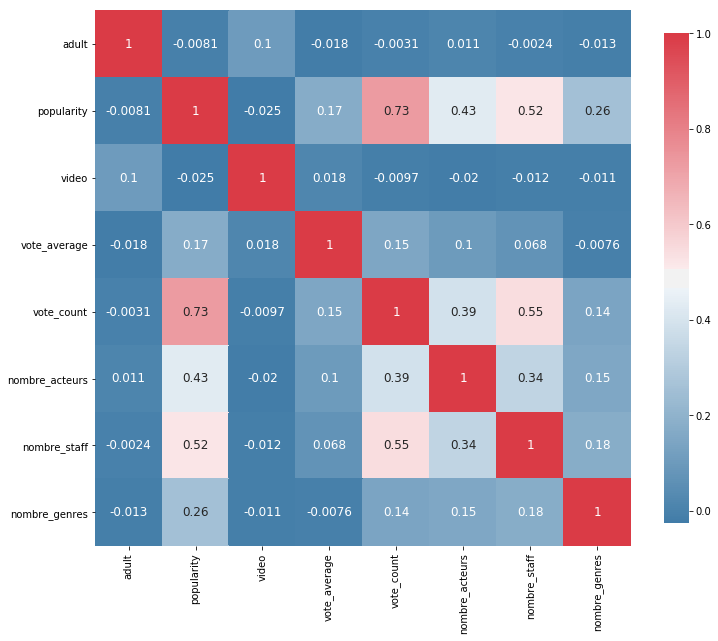

In [17]:
plot_correlation_map(analyse_films)

### Remarques :
* On remarque que le nombre de vote est extrêmement corrélé avec la popularité, c’est logique puisque si le film est populaire plus de personnes vont donner leurs avis sur sa qualité.
* Le vote average est très légèrement corrélé avec la popularité, le nombre de votes.Donc la popularité du film n'implique pas qu'il soit bien noté par les internautes.
* La popularité et le nombre de vote sont très corrélés avec le nombre de membres du staff et le nombre d'acteurs. Ils sont aussi légèrement corrélé avec nombre de genres dans lesquels le film est catégorisée. Ce qui est logique puisque les grandes productions attirent le public.

In [18]:
sauvegarde['release_date'] = pd.to_datetime(sauvegarde['release_date'])
sauvegarde.head()

,adult,genre_ids,tmdbId,original_language,popularity,release_date,video,vote_average,vote_count,nombre_acteurs,nombre_staff,nombre_genres
0,False,"[16, 35, 10751]",862,en,22.773,1995-10-30,False,7.9,9550,39,195,3
1,False,"[12, 14, 10751]",8844,en,2.947,1995-12-15,False,7.1,5594,32,94,3
2,False,"[35, 10749]",15602,en,6.076,1995-12-22,False,6.5,140,7,50,2
3,False,"[35, 18, 10749]",31357,en,2.917,1995-12-22,False,6.1,55,14,14,3
4,False,[35],11862,en,6.817,1995-02-10,False,6.1,288,12,7,1


## Nombre de films en fonction des mois :

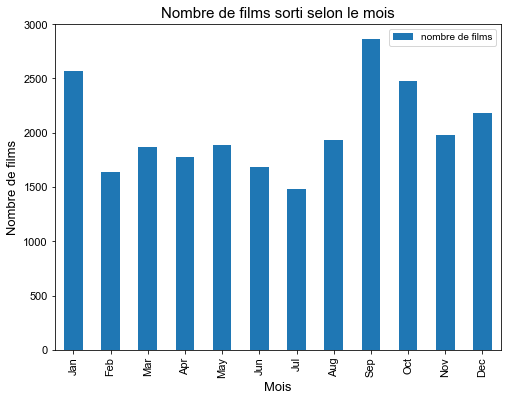

In [19]:
month_release = sauvegarde['release_date'].dt.month
number_of_release = month_release.value_counts().sort_index()
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
number_of_release = pd.DataFrame(number_of_release)
number_of_release['month'] = months
number_of_release.rename(columns = {'release_date':'nombre de films'},inplace=True)
number_of_release.plot(x='month',kind='bar',fontsize = 11,figsize=(8,6))
plt.title('Nombre de films sorti selon le mois',fontsize = 15)
plt.xlabel('Mois',fontsize = 13)
plt.ylabel('Nombre de films',fontsize = 13)
sns.set_style("darkgrid")

### Remarques :
* On remarque des piques de productions durant le mois de janvier (début d’année), et durant le mois de septembre.

## Popularité des films en fonction des mois :

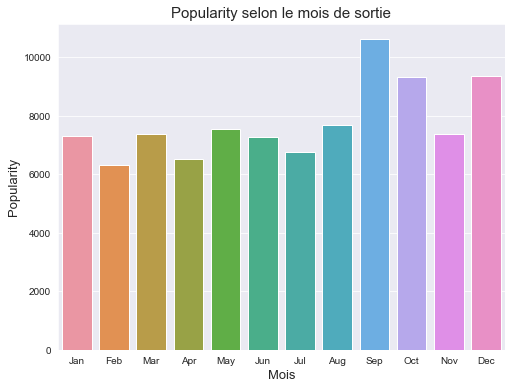

In [20]:
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(8,6))
index_release_date = sauvegarde.set_index('release_date')
groupby_index = index_release_date.groupby([(index_release_date.index.month)])
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_popularity = groupby_index['popularity'].sum()
monthly_popularity = pd.DataFrame(monthly_popularity)
monthly_popularity.head()
monthly_popularity_bar = sns.barplot(x = monthly_popularity.index, y = monthly_popularity['popularity'], data = monthly_popularity)
monthly_popularity_bar.axes.set_title('Popularity selon le mois de sortie',fontsize = 15)
monthly_popularity_bar.set_xlabel("Mois",fontsize = 13)
monthly_popularity_bar.set_ylabel("Popularity",fontsize = 13)
monthly_popularity_bar.set_xticklabels(month_list)
plt.show()


### Remarques :
* On remarque que la popularité du film est distribuée de manière assez uniforme sur les mois de l’année.

<h1>3 Catégorisation non supervisée -regroupement des acteurs-   : </h1>

<h2>I - Selon le genre des films dans lequels ils ont joué :</h2>
Chaque acteur est caracterisé par : 
<li>Pour chaque genre : le nombre de films auquels il a partcipé.
<li>Le nombre total de films dans lesquels il a joué.


<font size="+2" color="GREEN">**1 - Netoyage des données :**</font>

In [21]:
#On cree une copie des dataframes
movies_copie = movies.copy(True)
print("Movies :  (Taille, Nombre d'attributs) = ",movies_copie.shape)
links_copie = links.copy(True)
print("Links : (Taille, Nombre d'attributs) = ",links_copie.shape)
films_copie = films.copy(True)
print("Films : (Taille, Nombre d'attributs) = ",films_copie.shape)

Movies :  (Taille, Nombre d'attributs) =  (27278, 3)
Links : (Taille, Nombre d'attributs) =  (27026, 3)
Films : (Taille, Nombre d'attributs) =  (24326, 14)


In [22]:
# jointure entre les films et les liens sur l'attribut : movieId
intermediate_clustering_genre = movies_copie.join(links_copie,lsuffix='_caller', rsuffix='_other')
# jointure entre les films et les donnes d'enrichissement sur l'attribut : tmdbId
intermediate_clustering_genre = intermediate_clustering_genre.join(films_copie,how = 'inner',lsuffix='_caller', rsuffix='_other')
print("Résultat de la jointure : (Taille, Nombre d'attributs) = ",intermediate_clustering_genre.shape)
intermediate_clustering_genre.head()

Résultat de la jointure : (Taille, Nombre d'attributs) =  (24326, 20)


,movieId_caller,title_caller,genres,movieId_other,imdbId,tmdbId_caller,adult,backdrop_path,genre_ids,tmdbId_other,original_language,original_title,overview,popularity,poster_path,release_date,title_other,video,vote_average,vote_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,114709.0,862.0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",22.773,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,Toy Story,False,7.9,9550
1,2,Jumanji (1995),Adventure|Children|Fantasy,2.0,113497.0,8844.0,False,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,2.947,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,1995-12-15,Jumanji,False,7.1,5594
2,3,Grumpier Old Men (1995),Comedy|Romance,3.0,113228.0,15602.0,False,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.076,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,Grumpier Old Men,False,6.5,140
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,4.0,114885.0,31357.0,False,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",2.917,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,1995-12-22,Waiting to Exhale,False,6.1,55
4,5,Father of the Bride Part II (1995),Comedy,5.0,113041.0,11862.0,False,/cZs50rEk4T13qWedon0uCnbYQzW.jpg,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.817,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,Father of the Bride Part II,False,6.1,288


In [23]:
# On recupere tout les genres
def genres():
    # on recupere la liste des genres
    m=intermediate_clustering_genre['genres'].values.ravel()
    dico={}
    cpt=0
    # pour chaque genre, on split et on regarde si il est deja present
    for s in m:
        a=s.split('|')
        for s2 in a:
            if s2 not in dico.keys():
                dico[s2]=cpt
                cpt+=1
    return dico
dictionnaire_genres=genres()
print("Les genres sont : ",dictionnaire_genres)

Les genres sont :  {'Adventure': 0, 'Animation': 1, 'Children': 2, 'Comedy': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Mystery': 11, 'Sci-Fi': 12, 'IMAX': 13, 'War': 14, 'Musical': 15, 'Documentary': 16, 'Western': 17, 'Film-Noir': 18, '(no genres listed)': 19}


In [24]:
# on cree un nouveau dataframe pour stocker les acteurs
# ce dataframe est crée a partir du dictionnaire des acteurs inversé
acteursGenre = pd.Series(actors_inv).to_frame()
acteursGenre.columns = ["acteur"]
# On rajoute en colonne tout les genres "dumby coding"
for genre in dictionnaire_genres:
    if genre == '(no genres listed)':
        acteursGenre["total"] = 0
    else:
        acteursGenre[genre] = 0
acteursGenre.head()

,acteur,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,total
0,Tom Hanks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tim Allen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Don Rickles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jim Varney,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wallace Shawn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# on recupere le compte de fims pour chaque genre et pour chaque acteur
def function_util(currentGenres,x):
    i = intermediate_clustering_genre[intermediate_clustering_genre['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    i = i[0]
    for j in range(len(actor[i])):
        index = actors.get(actor[i][j]['name'])
        acteursGenre.at[index, 'total'] = acteursGenre.at[index, 'total'] + 1
        for genre in currentGenres:
            if genre == '(no genres listed)':
                pass
            else:
                acteursGenre.at[index, genre] = acteursGenre.at[index, genre] + 1  
intermediate_clustering_genre.apply(lambda x : function_util(x['genres'].split('|'),x), axis = 1)
print("done")
"""
for i in range(result.shape[0]):
    intermediate = result.iloc[i] 
    currentGenres =[]
    currentGenres = intermediate['genres'].split('|')
    for j in range(len(actor[i])):
        index = actors.get(actor[i][j]['name'])
        acteurs.at[index, 'total'] = acteurs.at[index, 'total'] + 1
        for genre in currentGenres:
            if genre == '(no genres listed)':
                pass
            else:
                acteurs.at[index, genre] = acteurs.at[index, genre] + 1   
"""

done


"\nfor i in range(result.shape[0]):\n    intermediate = result.iloc[i] \n    currentGenres =[]\n    currentGenres = intermediate['genres'].split('|')\n    for j in range(len(actor[i])):\n        index = actors.get(actor[i][j]['name'])\n        acteurs.at[index, 'total'] = acteurs.at[index, 'total'] + 1\n        for genre in currentGenres:\n            if genre == '(no genres listed)':\n                pass\n            else:\n                acteurs.at[index, genre] = acteurs.at[index, genre] + 1   \n"

<font size="+2" color="GREEN">**2- Application -Kmoyennes-:**</font>

### Aprés nettoyage voici la base sur laquelle nous allons appliquer notre Algorithme : 

In [26]:
acteursGenre.head()

,acteur,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,total
0,Tom Hanks,5,3,5,17,8,9,27,11,4,...,6,5,5,1,3,3,2,3,0,54
1,Tim Allen,3,3,4,9,4,9,15,5,1,...,3,1,2,1,3,1,0,2,0,28
2,Don Rickles,3,2,3,7,3,5,13,3,5,...,1,2,0,0,1,1,0,1,0,23
3,Jim Varney,2,1,2,9,2,2,7,3,2,...,0,0,2,1,0,1,0,2,0,18
4,Wallace Shawn,6,6,7,24,5,16,30,9,6,...,3,1,2,0,4,4,3,5,0,67


In [28]:
acteursGenre.dtypes

acteur         object
War             int64
Mystery         int64
Fantasy         int64
Crime           int64
Romance         int64
total           int64
Drama           int64
Thriller        int64
Animation       int64
Musical         int64
IMAX            int64
Adventure       int64
Horror          int64
Documentary     int64
Children        int64
Comedy          int64
Action          int64
Sci-Fi          int64
Film-Noir       int64
Western         int64
dtype: object

In [29]:
# On genere un fichier csv pour des utilisations avenir
acteursGenre.to_csv('acteurs_clustering_genres.csv')

In [66]:
# On normalise en vue de l'application de l'algorithme de clustering
acteursGenre=acteursGenre.drop(['acteur'],axis=1)
acteursGenre = km.normalisation(acteursGenre)  
acteursGenre.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,total
0,0.263158,0.3,0.263158,0.232877,0.615385,0.219512,0.252336,0.407407,0.133333,0.277778,0.3750,0.416667,0.384615,0.25,0.200000,0.375,0.117647,0.500000,0.0,0.255924
1,0.157895,0.3,0.210526,0.123288,0.307692,0.219512,0.140187,0.185185,0.033333,0.083333,0.1875,0.083333,0.153846,0.25,0.200000,0.125,0.000000,0.333333,0.0,0.132701
2,0.157895,0.2,0.157895,0.095890,0.230769,0.121951,0.121495,0.111111,0.166667,0.027778,0.0625,0.166667,0.000000,0.00,0.066667,0.125,0.000000,0.166667,0.0,0.109005
3,0.105263,0.1,0.105263,0.123288,0.153846,0.048780,0.065421,0.111111,0.066667,0.000000,0.0000,0.000000,0.153846,0.25,0.000000,0.125,0.000000,0.333333,0.0,0.085308
4,0.315789,0.6,0.368421,0.328767,0.384615,0.390244,0.280374,0.333333,0.200000,0.277778,0.1875,0.083333,0.153846,0.00,0.266667,0.500,0.176471,0.833333,0.0,0.317536


<font size="+2" color="GREEN">**3 - Resultats:**</font>

## Quelle valeur à donner pour k ?

### Optimisation de la valeur de k selon l'index de dunn et de xb :

In [67]:
# on calcul l'index de dunn et de xb pour differntes valeurs de k
time=[]
dunn= []
xb =[]
for k in range(5,30):
    time.append(k)
    les_centres, l_affectation = km.kmoyennes(k, acteursGenre.iloc[0:100], 0.05, 100)
    dunn.append(cli.evaluation("Dunn",acteursGenre.iloc[0:100],les_centres,l_affectation))
    xb.append(cli.evaluation("XB",acteursGenre.iloc[0:100],les_centres,l_affectation))
print("best k according to dunn : ",time[dunn.index(min(dunn))])
print("best k according to xb : ",time[xb.index(min(xb))]) 

best k according to dunn :  8
best k according to xb :  8


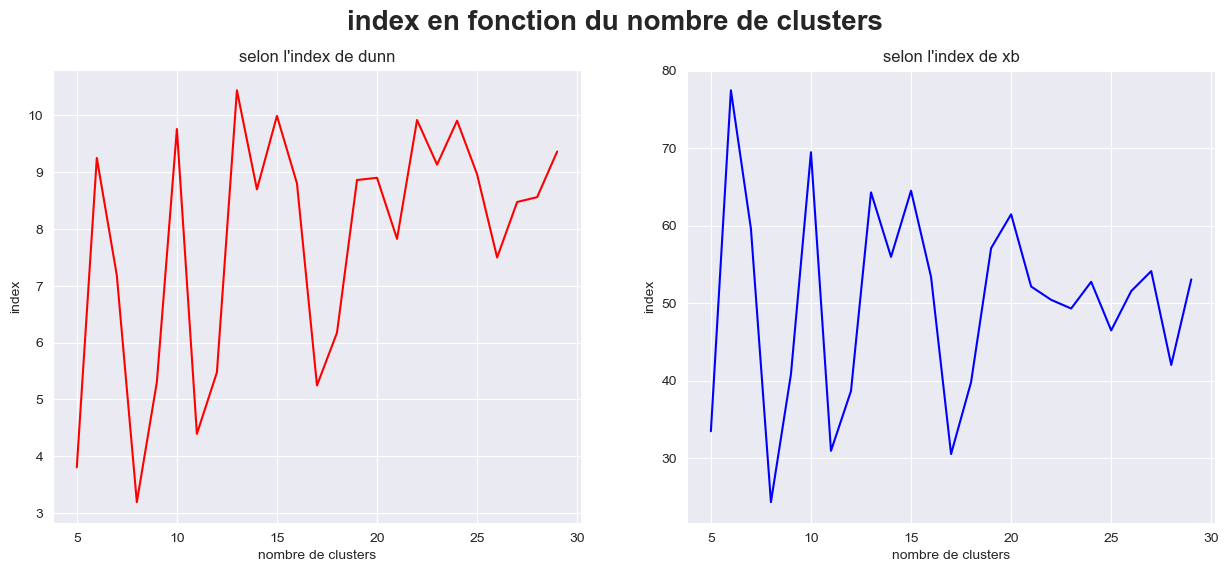

In [68]:
# affichage des resultats
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(15,6), dpi = 100)
plt.suptitle("index en fonction du nombre de clusters",fontsize=20, fontweight='bold')
# plot 1
p1= plt.subplot(121)
p1.set_title("selon l'index de dunn")
#p1.set_xlabel("itérations")
p1.set_ylabel("index")
p1.set_xlabel("nombre de clusters")
p1.plot(time, dunn,color="red")
# plot 2
p2= plt.subplot(122)
p2.set_title("selon l'index de xb")
#p2.set_xlabel("itérations")
p2.set_ylabel("index")
p2.set_xlabel("nombre de clusters")
p2.plot(time, xb,color="blue")

In [69]:
les_centres, l_affectation = km.kmoyennes(8, acteursGenre.iloc[0:100], 0.05, 100)

### Les centres :

In [70]:
les_centres

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,total
0,0.273684,0.400000,0.284211,0.268493,0.415385,0.278049,0.256075,0.244444,0.226667,0.238889,0.400000,0.216667,0.215385,0.150000,0.293333,0.450000,0.117647,0.400000,0.080000,0.268246
1,0.181818,0.236364,0.196172,0.136986,0.188811,0.139690,0.105353,0.094276,0.133333,0.078283,0.125000,0.106061,0.083916,0.159091,0.121212,0.193182,0.080214,0.136364,0.036364,0.122361
2,0.077562,0.131579,0.099723,0.046864,0.121457,0.035944,0.044270,0.042885,0.040351,0.036550,0.105263,0.061404,0.044534,0.078947,0.017544,0.085526,0.024768,0.087719,0.000000,0.048890
3,0.196172,0.227273,0.114833,0.149440,0.146853,0.148559,0.164826,0.134680,0.136364,0.141414,0.284091,0.121212,0.209790,0.000000,0.103030,0.113636,0.139037,0.227273,0.090909,0.172770
4,0.058752,0.034884,0.047736,0.021982,0.073345,0.015882,0.019996,0.017227,0.014729,0.017442,0.020349,0.015504,0.019678,0.000000,0.009302,0.005814,0.002736,0.007752,0.009302,0.021492
5,0.218045,0.128571,0.112782,0.199609,0.175824,0.170732,0.202937,0.232804,0.195238,0.226190,0.303571,0.309524,0.197802,0.107143,0.104762,0.214286,0.151261,0.000000,0.142857,0.208531
6,0.263158,0.000000,0.026316,0.140411,0.173077,0.103659,0.123832,0.175926,0.066667,0.145833,0.078125,0.083333,0.192308,0.000000,0.050000,0.031250,0.088235,0.166667,0.000000,0.131517


In [71]:
# on recupere le resulatat de l'affectation
actors_clusters = copy.deepcopy(l_affectation)
for i in actors_clusters:
    for j in range(len(actors_clusters[i])):
        actors_clusters[i][j] = actors_inv[actors_clusters[i][j]]
resultat_clustering_genres = pd.Series(actors_clusters).to_frame()
resultat_clustering_genres.columns = ["clusters selon genres"]

### Les clusters :

In [72]:
resultat_clustering_genres.head()

,clusters selon genres
0,"[Tom Hanks, Wallace Shawn, Sherry Lynn, Jack A..."
2,"[Tim Allen, Don Rickles, Bill Farmer, Phil Pro..."
3,"[Jim Varney, Annie Potts, John Morris, Erik vo..."
1,"[John Ratzenberger, Laurie Metcalf, R. Lee Erm..."
4,"[Sarah Freeman, Penn Jillette, Spencer Aste, G..."


<h2>II - Selon la "qualité" de l'acteur :</h2>
Chaque acteur est caracterisé par : 
<li>La popularité des films dans lesquels ils tournent.
<li>Le nombre total des films dans lesquels il a partcipé.
<li>Leurs note moyenne.
<li>Le nombre de personnes qui ont participé au vote des films dans lesquels ils ont tourné.

<font size="+2" color="GREEN">**1 - Netoyage des données :**</font>

In [73]:
#On cree le dataframe sur lequel on va appliquer notre algorithme de clustering
acteursQuality = pd.Series(actors_inv).to_frame()
acteursQuality.columns = ["acteur"]
acteursQuality['vote_average']=0
acteursQuality['vote_count']=0
acteursQuality['popularity']=0
acteursQuality['total'] = 0 
acteursQuality.tail()

,acteur,vote_average,vote_count,popularity,total
162905,Rachel Heller,0,0,0,0
162906,Kelly Bensimon,0,0,0,0
162907,Chloe Levine,0,0,0,0
162908,Bettina Mangiaracina,0,0,0,0
162909,Luke Marcus Rosen,0,0,0,0


In [74]:
# on parcours les acteurs et on recupere a chaque fois les prametres voulus
for i in range(intermediate_clustering_genre.shape[0]):
    intermediate = intermediate_clustering_genre.iloc[i] 
    for j in range(len(actor[i])):
        index = actors.get(actor[i][j]['name'])
        acteursQuality.at[index, 'vote_average'] = acteursQuality.at[index, 'vote_average'] + intermediate['vote_average']
        acteursQuality.at[index, 'vote_count'] = acteursQuality.at[index, 'vote_count'] + intermediate['vote_count']
        if not math.isnan(intermediate['popularity']):
            acteursQuality.at[index, 'popularity'] = acteursQuality.at[index, 'popularity'] + intermediate['popularity']
        acteursQuality.at[index, 'total'] = acteursQuality.at[index, 'total'] + 1

acteursQuality["vote_average"] = acteursQuality["vote_average"]/acteursQuality["total"]
acteursQuality["vote_count"] = acteursQuality["vote_count"]/acteursQuality["total"]
acteursQuality["popularity"] = acteursQuality["popularity"]/acteursQuality["total"]
acteursQuality=acteursQuality.drop(['total'],axis=1)
acteursQuality.head()

,acteur,vote_average,vote_count,popularity
0,Tom Hanks,5.981818,430.600000,3.672727
1,Tim Allen,5.961538,780.000000,4.423077
2,Don Rickles,5.909091,734.727273,4.500000
3,Jim Varney,6.150000,816.750000,4.300000
4,Wallace Shawn,5.921875,295.718750,3.437500


<font size="+2" color="GREEN">**2 - Application -Kmoyennes- :**</font>

### Aprés nettoyage voici la base sur laquelle nous allons appliquer notre Algorithme : 

In [75]:
acteursQuality.head()

,acteur,vote_average,vote_count,popularity
0,Tom Hanks,5.981818,430.600000,3.672727
1,Tim Allen,5.961538,780.000000,4.423077
2,Don Rickles,5.909091,734.727273,4.500000
3,Jim Varney,6.150000,816.750000,4.300000
4,Wallace Shawn,5.921875,295.718750,3.437500


In [ ]:
# On genere un fichier csv pour des utilisations avenir
acteursQuality.to_csv('acteurs_clustering_quality.csv')

In [ ]:
#Normalisation
acteursQuality=acteursQuality.drop(['acteur'],axis=1)
acteursQuality = km.normalisation(acteursQuality)  
acteursQuality.head()

,vote_average,vote_count,popularity
0,0.598182,0.020446,0.069297
1,0.596154,0.037037,0.083454
2,0.590909,0.034887,0.084906
3,0.615000,0.038782,0.081132
4,0.592187,0.014042,0.064858


<font size="+2" color="GREEN">**3 - Resultats:**</font>

## Quelle valeur à donner pour k ?

### Optimisation de la valeur de k selon l'index de dunn et de xb :

In [ ]:
# on calcul l'index de dunn et de xb pour differntes valeurs de k
time=[]
dunn= []
xb =[]
for k in range(5,30):
    time.append(k)
    les_centres, l_affectation = km.kmoyennes(k, acteursQuality.iloc[0:1000], 0.05, 100)
    dunn.append(cli.evaluation("Dunn",acteursQuality.iloc[0:1000],les_centres,l_affectation))
    xb.append(cli.evaluation("XB",acteursQuality.iloc[0:1000],les_centres,l_affectation))
print("best k according to dunn : ",time[dunn.index(min(dunn))])
print("best k according to xb : ",time[xb.index(min(xb))]) 

In [ ]:
# affichage des resultats
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(15,6), dpi = 100)
plt.suptitle("index en fonction du nombre de clusters",fontsize=20, fontweight='bold')
# plot 1
p1= plt.subplot(121)
p1.set_title("selon l'index de dunn")
#p1.set_xlabel("itérations")
p1.set_ylabel("index")
p1.set_xlabel("nombre de clusters")
p1.plot(time, dunn,color="red")
# plot 2
p2= plt.subplot(122)
p2.set_title("selon l'index de xb")
#p2.set_xlabel("itérations")
p2.set_ylabel("index")
p2.set_xlabel("nombre de clusters")
p2.plot(time, xb,color="blue")

In [ ]:
les_centres_quality, l_affectation_quality = km.kmoyennes(8, acteursQuality.iloc[0:1000], 0.05, 100)

### Les centres

In [ ]:
les_centres_quality

### Les clusters

In [ ]:
actors_clusters = copy.deepcopy(l_affectation_quality)
for i in actors_clusters:
    for j in range(len(actors_clusters[i])):
        actors_clusters[i][j] = actors_inv[actors_clusters[i][j]]
resultat_clustering_quality = pd.Series(actors_clusters).to_frame()
resultat_clustering_quality.columns = ["clusters selon quality"]
resultat_clustering_quality

<h1>3 Regression -Prédiction de la note du film-   : </h1>

On va predir l'attribut "vote average" a partir de :
<li> Du genre, i.e. utilisation du <b>Dumby coding</b>.
<li> De la langue, i.e. utilisation du <b>Dumby coding</b>.
<li> De la popularité.			
<li> Du nombre de personne qui ont voté.
<li> Pour adultes ou pas.

<font size="+2" color="GREEN">**1 - Netoyage des données :**</font>

In [27]:
# jointure entre les films et les liens sur l'attribut : movieId
regression_vote_average = movies_copie.join(links_copie,lsuffix='_caller', rsuffix='_other')
# jointure entre les films et les donnes d'enrichissement sur l'attribut : tmdbId
regression_vote_average = regression_vote_average.join(films_copie,how = 'inner',lsuffix='_caller', rsuffix='_other')
print("Resultat de la jointure : (taille,nombre d'attributs)",regression_vote_average.shape)
regression_vote_average=regression_vote_average.drop(['movieId_other','imdbId','tmdbId_caller','backdrop_path','genre_ids','tmdbId_other','original_title','overview','poster_path','release_date','title_other','video','title_caller'],axis=1)
regression_vote_average.tail()

Resultat de la jointure : (taille,nombre d'attributs) (24326, 20)


,movieId_caller,genres,adult,original_language,popularity,vote_average,vote_count
26903,129354,Comedy|Crime|Drama|Romance,False,de,1.911,5.7,14
26904,129358,Adventure|Comedy|Fantasy,False,de,1.568,4.4,11
26905,129360,Drama,False,ko,3.726,6.6,57
26906,129362,Documentary,False,fi,0.800,6.7,6
26907,129370,Adventure|Animation|Children|Comedy,False,en,1.775,4.3,19


### Traitement des données categorielles (Dumby-Coding) :

In [28]:
regression_vote_average['adulte'] = 0
langues = []
genres = []
def dumby_coding(x):
    currentGenres = x['genres'].split('|')
    currentLanguage = x['original_language']
    currentAdult = x['adult']
    i = regression_vote_average[regression_vote_average['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    index = i[0]
    if (currentLanguage!='' and isinstance(currentLanguage,str)):
        if currentLanguage in langues :
            regression_vote_average.at[index, currentLanguage] = 1
        else:
            regression_vote_average[currentLanguage] = 0
            regression_vote_average.at[index, currentLanguage] = 1
            langues.append(currentLanguage)
    if currentAdult ==  True :
        regression_vote_average.at[index, 'adulte'] = 1
    elif  currentAdult ==  False :
        regression_vote_average.at[index, 'adulte'] = 0
    for genre in currentGenres:
        if (genre!='(no genres listed)') and genre!='':
            if genre in genres :
                regression_vote_average.at[index, genre] = 1
            else:
                regression_vote_average[genre] = 0
                regression_vote_average.at[index, genre] = 1
                genres.append(genre)
regression_vote_average.apply(lambda x : dumby_coding(x), axis = 1)
print("done")

done


In [29]:
regression_vote_average.tail()

,movieId_caller,genres,adult,original_language,popularity,vote_average,vote_count,adulte,en,Adventure,...,te,jv,ms,lo,hr,ay,kn,ne,pa,ky
26903,129354,Comedy|Crime|Drama|Romance,False,de,1.911,5.7,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26904,129358,Adventure|Comedy|Fantasy,False,de,1.568,4.4,11,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26905,129360,Drama,False,ko,3.726,6.6,57,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26906,129362,Documentary,False,fi,0.800,6.7,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26907,129370,Adventure|Animation|Children|Comedy,False,en,1.775,4.3,19,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
regression_vote_average=regression_vote_average.drop(['original_language','genres','adult'],axis=1)
#regression_vote_average.set_index('movieId_caller',inplace=True)

<font size="+2" color="GREEN">**2 - Application -Monidres Carées- :**</font>

### Aprés nettoyage voici la base sur laquelle nous allons appliquer notre Algorithme : 

In [31]:
regression_vote_average.tail()

,movieId_caller,popularity,vote_average,vote_count,adulte,en,Adventure,Animation,Children,Comedy,...,te,jv,ms,lo,hr,ay,kn,ne,pa,ky
26903,129354,1.911,5.7,14,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26904,129358,1.568,4.4,11,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26905,129360,3.726,6.6,57,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26906,129362,0.800,6.7,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26907,129370,1.775,4.3,19,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# On genere un fichier csv pour des utilisations avenir
regression_vote_average.to_csv('regression_vote_average.csv')

### Construction du LabeledSet :

In [33]:
# on normalise
regression_vote_average_copy = regression_vote_average.copy()
regression_vote_average_copy = km.normalisation(regression_vote_average_copy)

In [34]:
vote_average_labeledSet=ls.LabeledSet(regression_vote_average.iloc[0:10000].shape[1]-2)
def build_labeledSet_regression(x):
    i = regression_vote_average[regression_vote_average['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    index = i[0]
    inter = x['vote_average']
    y = regression_vote_average_copy.iloc[index]
    y.drop(labels='movieId_caller',inplace = True)
    y.drop(labels='vote_average',inplace = True)
    vote_average_labeledSet.addExample(y,inter)
regression_vote_average.iloc[0:10000].apply(lambda x : build_labeledSet_regression(x), axis = 1)
print("done")

done


In [35]:
Cpc = cl.ClassifierMcDetScore(regression_vote_average.iloc[0:10000].shape[1]-2,0.01)
trainData,testData=ut.split(vote_average_labeledSet)

<font size="+2" color="GREEN">**3 - Resultats:**</font>

In [36]:
cost=[]
it=[]
for i in range(100):
    Cpc.train(trainData)
    cost.append(Cpc.cost(testData))
    it.append(i)

Text(0, 0.5, 'Regret')

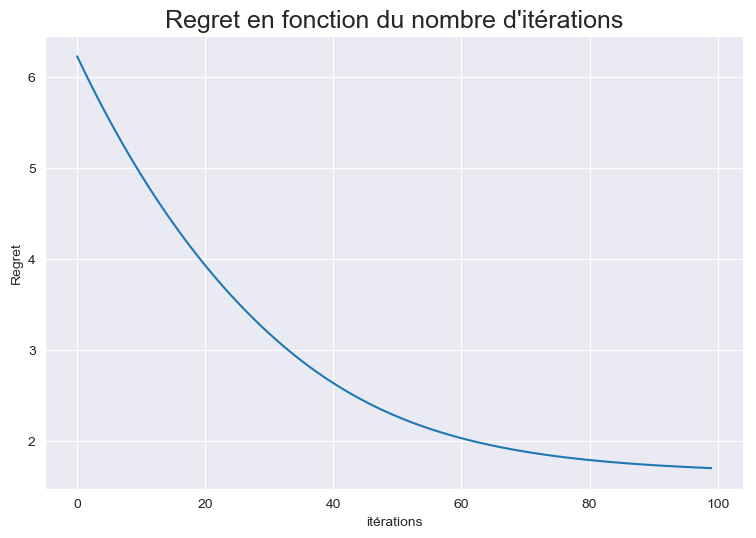

In [37]:
#Dessin de la figure
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)

plt.plot(it,cost)
plt.title("Regret en fonction du nombre d'itérations", fontsize=18)
plt.xlabel("itérations")
plt.ylabel("Regret")

In [38]:
# On recupere le score de chaque ligne
resultat_regression = (regression_vote_average.iloc[0:10000]).copy()
resultat_regression["prediction"] = 0
# on parcours le labeled set et on recupere le score
for i in range(vote_average_labeledSet.size()-1):
    resultat_regression.loc[i,'prediction'] = Cpc.score(vote_average_labeledSet.getX(i))
resultat_regression.head()

,movieId_caller,popularity,vote_average,vote_count,adulte,en,Adventure,Animation,Children,Comedy,...,jv,ms,lo,hr,ay,kn,ne,pa,ky,prediction
0,1.0,22.773,7.9,9550.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.661005
1,2.0,2.947,7.1,5594.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.729945
2,3.0,6.076,6.5,140.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.980854
3,4.0,2.917,6.1,55.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.172237
4,5.0,6.817,6.1,288.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.292592


### Prediction de la popularité du film :

Comme on a vu precedemment dans la matrice de correlations, la popularité d'un film est corelle avec le nombre d'acteur  et le nombre de memebres du staff ainsi qu'avec le nombre de votes sur le film, on va utiliser ces trois attributs pour predir la popularite d'un film

<font size="+2" color="GREEN">**1 - Netoyage des données :**</font>

In [39]:
regression_popularity = sauvegarde.copy()
regression_popularity = regression_popularity.drop(['adult','genre_ids','original_language','release_date','video','vote_average','nombre_genres'],axis=1)

<font size="+2" color="GREEN">**2 - Application -Monidres Carées- :**</font>

### Aprés nettoyage voici la base sur laquelle nous allons appliquer notre Algorithme : 

In [40]:
regression_popularity.head()

,tmdbId,popularity,vote_count,nombre_acteurs,nombre_staff
0,862,22.773,9550,39,195
1,8844,2.947,5594,32,94
2,15602,6.076,140,7,50
3,31357,2.917,55,14,14
4,11862,6.817,288,12,7


In [42]:
# on normalise
regression_popularity_copy = regression_popularity.copy()
regression_popularity_copy = regression_popularity_copy.drop(["popularity",'tmdbId'],axis = 1)
regression_popularity_copy = km.normalisation(regression_popularity_copy)

### Construction du LabeledSet :

In [43]:
popularity_labeledSet=ls.LabeledSet(regression_popularity.iloc[0:10000].shape[1]-2)
def build_labeledSet_regression_popularity(x):
    i = regression_popularity[regression_popularity['tmdbId']==x['tmdbId']].index.values.astype(int)
    index = i[0]
    inter = x['popularity']
    y = regression_popularity_copy.iloc[index]
    popularity_labeledSet.addExample(y,inter)
regression_popularity.iloc[0:10000].apply(lambda x : build_labeledSet_regression_popularity(x), axis = 1)
print("done")

done


In [44]:
CpcPop = cl.ClassifierMcDetScore(regression_popularity.iloc[0:10000].shape[1]-2,0.5)
trainDataPop,testDataPop=ut.split(popularity_labeledSet)

<font size="+2" color="GREEN">**3 - Resultats:**</font>

In [46]:
cost_pop=[]
it_pop=[]
for i in range(100):
    CpcPop.train(trainDataPop)
    cost_pop.append(CpcPop.cost(testDataPop))
    it_pop.append(i)

Text(0, 0.5, 'Regret')

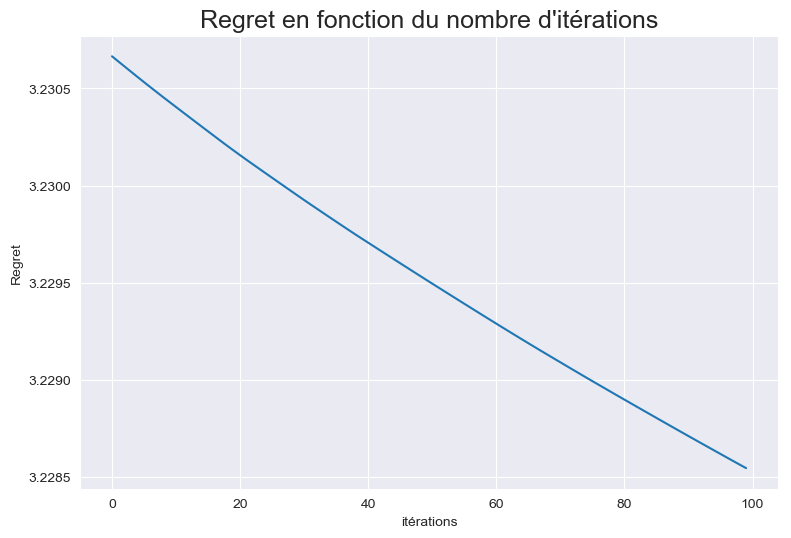

In [47]:
#Dessin de la figure
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)

plt.plot(it_pop,cost_pop)
plt.title("Regret en fonction du nombre d'itérations", fontsize=18)
plt.xlabel("itérations")
plt.ylabel("Regret")

In [48]:
# On recupere le score de chaque ligne
resultat_regression_popularity = (regression_popularity.iloc[0:10000]).copy()
resultat_regression_popularity["prediction"] = 0
# on parcours le labeled set et on recupere le score
for i in range(popularity_labeledSet.size()-1):
    resultat_regression_popularity.loc[i,'prediction'] = CpcPop.score(popularity_labeledSet.getX(i))
resultat_regression_popularity.head()

,tmdbId,popularity,vote_count,nombre_acteurs,nombre_staff,prediction
0,862.0,22.773,9550.0,39.0,195.0,7.917752
1,8844.0,2.947,5594.0,32.0,94.0,5.593671
2,15602.0,6.076,140.0,7.0,50.0,1.747597
3,31357.0,2.917,55.0,14.0,14.0,2.161732
4,11862.0,6.817,288.0,12.0,7.0,1.760609


<h1>3 Classification selon la qualité du film -One Against All-   : </h1>

On va classifier sur  l'attribut "vote average" a partir de :
<li> Du genre, i.e. utilisation du <b>Dumby coding</b>.
<li> De la popularité.			
<li> Du nombre de personne qui ont voté.
<li> On va discrétiser l'attribut "vote average" qui est continu en quatres classes {"mauvais" : 0,"bien" : 1,"tres bien" :2,"excellent" : 3} en utilisant les quartiles.

<font size="+2" color="GREEN">**1 - Netoyage des données :**</font>

In [49]:
# jointure entre les films et les liens sur l'attribut : movieId
classification_vote_average = movies_copie.join(links_copie,lsuffix='_caller', rsuffix='_other')
# jointure entre les films et les donnes d'enrichissement sur l'attribut : tmdbId
classification_vote_average = classification_vote_average.join(films_copie,how = 'inner',lsuffix='_caller', rsuffix='_other')
print("Resultat de le jointure : (taille, nombre de lignes) =",classification_vote_average.shape)
classification_vote_average=classification_vote_average.drop(['movieId_other','adult',"original_language",'imdbId','tmdbId_caller','backdrop_path','genre_ids','tmdbId_other','original_title','overview','poster_path','release_date','title_other','video','title_caller'],axis=1)
classification_vote_average.tail()

Resultat de le jointure : (taille, nombre de lignes) = (24326, 20)


,movieId_caller,genres,popularity,vote_average,vote_count
26903,129354,Comedy|Crime|Drama|Romance,1.911,5.7,14
26904,129358,Adventure|Comedy|Fantasy,1.568,4.4,11
26905,129360,Drama,3.726,6.6,57
26906,129362,Documentary,0.800,6.7,6
26907,129370,Adventure|Animation|Children|Comedy,1.775,4.3,19


### Histogramme de la distribution du vote average

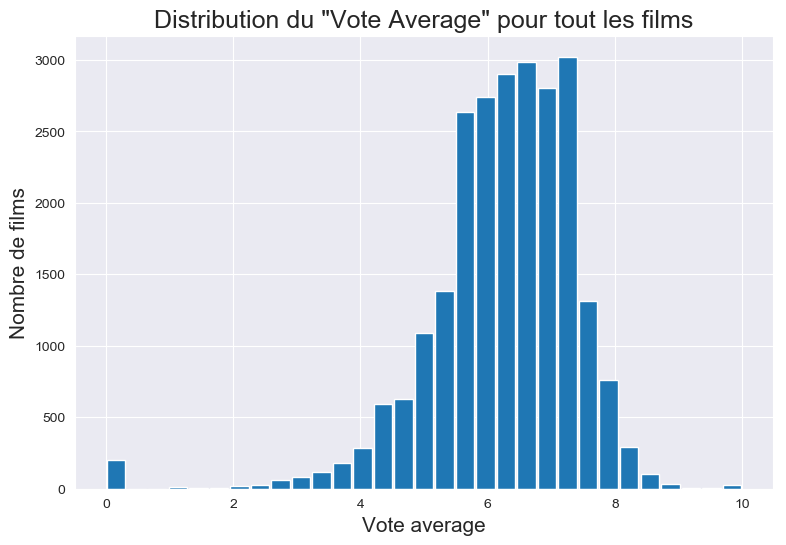

In [50]:
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.xlabel('Vote average', fontsize = 15)
plt.ylabel('Nombre de films', fontsize=15)
#titre
plt.title('Distribution du \"Vote Average\" pour tout les films', fontsize=18)
plt.hist(films['vote_average'], rwidth = 0.9, bins =31)
plt.show()

In [51]:
#on recupere les quantiles 
quantiles = classification_vote_average["vote_average"].quantile(q=[0.25,0.5,0.75])
classes = {"mauvais" : 0,"bon" : 1,"tres bon" :2,"excellent" : 3} 
classes_inverse = {0 :"mauvais",1 :"bon",2 : "tres bon", 3:"excellent"}
print("les quantiles sont : \n",quantiles)

les quantiles sont : 
 0.25    5.7
0.50    6.4
0.75    7.0
Name: vote_average, dtype: float64


In [52]:
# on applique la discretisation + dumby coding
genres = []
def discretise_vote_average(x):
    currentGenres = x['genres'].split('|')
    currentVote = x["vote_average"]
    i = classification_vote_average[classification_vote_average['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    index = i[0]
    if currentVote<quantiles[0.25]:
        classification_vote_average.at[index, "vote_average"] = classes["mauvais"]
    elif (currentVote>=quantiles[0.25]) and (currentVote<quantiles[0.5]):
        classification_vote_average.at[index, "vote_average"] = classes["bon"]
    elif (currentVote>=quantiles[0.5]) and (currentVote<quantiles[0.75]):
        classification_vote_average.at[index, "vote_average"] = classes["tres bon"]
    elif (currentVote>=quantiles[0.75]):
        classification_vote_average.at[index, "vote_average"] = classes["excellent"]
    for genre in currentGenres:
        if (genre!='(no genres listed)') and genre!='':
            if genre in genres :
                classification_vote_average.at[index, genre] = 1
            else:
                classification_vote_average[genre] = 0
                classification_vote_average.at[index, genre] = 1
                genres.append(genre)
classification_vote_average.apply(lambda x : discretise_vote_average(x), axis = 1)
print("done")

done


In [53]:
# on cree une copie normalisee de la base
classification_vote_average = classification_vote_average.drop(["genres"],axis=1)
classification_vote_average_copie = classification_vote_average.copy(True)
classification_vote_average_copie = classification_vote_average_copie.drop(["vote_average"],axis=1)
classification_vote_average_copie = km.normalisation(classification_vote_average_copie)

<font size="+2" color="GREEN">**2 - Application:**</font>

### Aprés nettoyage voici la base sur laquelle nous allons appliquer notre Algorithme : 

In [54]:
classification_vote_average.tail()

,movieId_caller,popularity,vote_average,vote_count,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Thriller,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir
26903,129354,1.911,1.0,14,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
26904,129358,1.568,0.0,11,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
26905,129360,3.726,2.0,57,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26906,129362,0.800,2.0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26907,129370,1.775,0.0,19,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### One Against All

### Principe :
On veut classifier selon k classes différentes, on va avoir autant de classifieurs que de classes k. La classe qui va être attribuée a l'exemple est celle qui maximise la fonction score pour l'exemple.
$$Classe(y) = argmax(score_1(y),...,score_n(y))$$

In [55]:
# pour appliquer l'approche one against all , on va construire 4 labeled set differents
classifcation_mauvais_labeledSet=ls.LabeledSet(classification_vote_average.iloc[0:10000].shape[1]-1)
classifcation_bon_labeledSet=ls.LabeledSet(classification_vote_average.iloc[0:10000].shape[1]-1)
classifcation_tres_bon_labeledSet=ls.LabeledSet(classification_vote_average.iloc[0:10000].shape[1]-1)
classifcation_excellent_labeledSet=ls.LabeledSet(classification_vote_average.iloc[0:10000].shape[1]-1)
def build_labeledSet_classification(x):
    i = classification_vote_average[classification_vote_average['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    index = i[0]
    inter = x['vote_average']
    y = classification_vote_average_copie.iloc[index]
    y.drop(labels='movieId_caller',inplace = True)
    if inter == 0:
        classifcation_mauvais_labeledSet.addExample(y,[1])
        classifcation_bon_labeledSet.addExample(y,[-1])
        classifcation_tres_bon_labeledSet.addExample(y,[-1])
        classifcation_excellent_labeledSet.addExample(y,[-1])
    elif inter == 1:
        classifcation_bon_labeledSet.addExample(y,[1])
        classifcation_mauvais_labeledSet.addExample(y,[-1])
        classifcation_tres_bon_labeledSet.addExample(y,[-1])
        classifcation_excellent_labeledSet.addExample(y,[-1])
    elif inter == 2:
        classifcation_tres_bon_labeledSet.addExample(y,[1])
        classifcation_mauvais_labeledSet.addExample(y,[-1])
        classifcation_bon_labeledSet.addExample(y,[-1])
        classifcation_excellent_labeledSet.addExample(y,[-1])
    elif inter == 3:
        classifcation_excellent_labeledSet.addExample(y,[1])
        classifcation_mauvais_labeledSet.addExample(y,[-1])
        classifcation_bon_labeledSet.addExample(y,[-1])
        classifcation_tres_bon_labeledSet.addExample(y,[-1])
classification_vote_average.iloc[0:10000].apply(lambda x : build_labeledSet_classification(x), axis = 1)
print("done")

done


In [56]:
# perceptron
# on appelle les classifieurs
mauvais = cl.ClassfierPerceptron(classification_vote_average.iloc[0:10000].shape[1]-2,0.0001)
bon = cl.ClassfierPerceptron(classification_vote_average.iloc[0:10000].shape[1]-2,0.0001)
tres_bon = cl.ClassfierPerceptron(classification_vote_average.iloc[0:10000].shape[1]-2,0.0001)
excellent = cl.ClassfierPerceptron(classification_vote_average.iloc[0:10000].shape[1]-2,0.0001)

trainMauvais,testMauvais=ut.split(classifcation_mauvais_labeledSet)
trainBon,testBon=ut.split(classifcation_bon_labeledSet)
trainTresBon,testTresBon=ut.split(classifcation_tres_bon_labeledSet)
trainExcellent,testExcellent=ut.split(classifcation_excellent_labeledSet)
time = []
acc_mauvais = []
acc_bon = []
acc_tres_bon = []
acc_excellent = []
for i in range(100):
    mauvais.train(trainMauvais)
    bon.train(trainBon)
    tres_bon.train(trainTresBon)
    excellent.train(trainExcellent)
    time.append(i)
    acc_mauvais.append(mauvais.accuracy(testMauvais))
    acc_bon.append(bon.accuracy(testBon))
    acc_tres_bon.append(tres_bon.accuracy(testTresBon))
    acc_excellent.append(excellent.accuracy(testExcellent))

## Perceptron:

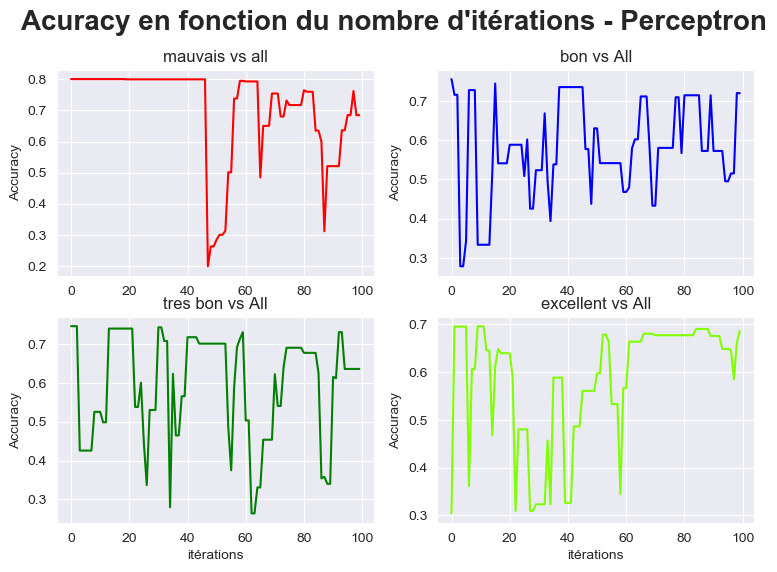

In [57]:
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.suptitle("Acuracy en fonction du nombre d'itérations - Perceptron",fontsize=20, fontweight='bold')
i+=1
# plot 1
p1= plt.subplot(221)
p1.set_title("mauvais vs all")
#p1.set_xlabel("itérations")
p1.set_ylabel("Accuracy")
p1.plot(time, acc_mauvais,color="red")
# plot 2
p2= plt.subplot(222)
p2.set_title("bon vs All")
#p2.set_xlabel("itérations")
p2.set_ylabel("Accuracy")
p2.plot(time, acc_bon,color="blue")
# plot 1
p3= plt.subplot(223)
p3.set_title("tres bon vs All")
p3.set_xlabel("itérations")
p3.set_ylabel("Accuracy")
p3.plot(time, acc_tres_bon,color="green")
# plot 1
p4= plt.subplot(224)
p4.set_title("excellent vs All")
p4.set_xlabel("itérations")
p4.set_ylabel("Accuracy")
p4.plot(time, acc_excellent,color="chartreuse")

### Perceptron kernelisé:

In [146]:
import random
class KernelPoly:
    def transform(self,x):
        res= np.array(x)
        for i in range(len(res)):
            for j in range(i): 
                np.append(res,res[i]*res[j])
        return np.append(res,1)

In [147]:
# perceptron kernelised
# on appelle les classifieurs
k=KernelPoly()
mauvais_kernel = cl.ClassifierPerceptronKernel(classification_vote_average.iloc[0:10000].shape[1]-1,0.0001,k)
bon_kernel = cl.ClassifierPerceptronKernel(classification_vote_average.iloc[0:10000].shape[1]-1,0.0001,k)
tres_bon_kernel = cl.ClassifierPerceptronKernel(classification_vote_average.iloc[0:10000].shape[1]-1,0.0001,k)
excellent_kernel = cl.ClassifierPerceptronKernel(classification_vote_average.iloc[0:10000].shape[1]-1,0.0001,k)

time_kernel = []
acc_mauvais_kernel = []
acc_bon_kernel = []
acc_tres_bon_kernel = []
acc_excellent_kernel = []
for i in range(10):
    mauvais_kernel.train(trainMauvais)
    bon_kernel.train(trainBon)
    tres_bon_kernel.train(trainTresBon)
    excellent_kernel.train(trainExcellent)
    time_kernel.append(i)
    acc_mauvais_kernel.append(mauvais_kernel.accuracy(testMauvais))
    acc_bon_kernel.append(bon_kernel.accuracy(testBon))
    acc_tres_bon_kernel.append(tres_bon_kernel.accuracy(testTresBon))
    acc_excellent_kernel.append(excellent_kernel.accuracy(testExcellent))

KeyboardInterrupt: 

In [ ]:
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.suptitle("Acuracy en fonction du nombre d'itérations - Perceptron Kernelisé",fontsize=20, fontweight='bold')
i+=1
# plot 1
p1= plt.subplot(221)
p1.set_title("mauvais vs all")
#p1.set_xlabel("itérations")
p1.set_ylabel("Accuracy")
p1.plot(time_kernel, acc_mauvais_kernel,color="red")
# plot 2
p2= plt.subplot(222)
p2.set_title("bon vs All")
#p2.set_xlabel("itérations")
p2.set_ylabel("Accuracy")
p2.plot(time_kernel, acc_bon_kernel,color="blue")
# plot 1
p3= plt.subplot(223)
p3.set_title("tres bon vs All")
p3.set_xlabel("itérations")
p3.set_ylabel("Accuracy")
p3.plot(time_kernel, acc_tres_bon_kernel,color="green")
# plot 1
p4= plt.subplot(224)
p4.set_title("excellent vs All")
p4.set_xlabel("itérations")
p4.set_ylabel("Accuracy")
p4.plot(time_kernel, acc_excellent_kernel,color="chartreuse")

## Bagging d'arbres de décision :

In [ ]:
mauvais_bag = bg.ClassifierBaggingTree(3,0.3,0.0,True)
bon_bag = bg.ClassifierBaggingTree(10,0.3,0.0,True)
tres_bon_bag = bg.ClassifierBaggingTree(10,0.3,0.0,True)
excellent_bag = bg.ClassifierBaggingTree(10,0.3,0.0,True)
#mauvais_bag.train(trainMauvais)

## Knn :

In [63]:
mauvais_knn = cl.ClassifierKNN(classification_vote_average.iloc[0:1000].shape[1]-2,30)
bon_knn = cl.ClassifierKNN(classification_vote_average.iloc[0:1000].shape[1]-2,30)
tres_bon_knn = cl.ClassifierKNN(classification_vote_average.iloc[0:1000].shape[1]-2,30)
excellent_knn = cl.ClassifierKNN(classification_vote_average.iloc[0:1000].shape[1]-2,30)

In [64]:
mauvais_knn.train(trainMauvais)
acc_knn = {"Accuracy mauvais vs all" : 0,"Accuracy bon vs all" : 0,"Accuracy tres bon vs all" : 0,"Accuracy excellent vs all" : 0}
acc_knn["Accuracy mauvais vs all"] = mauvais_knn.accuracy(testMauvais)
bon_knn.train(trainBon)
acc_knn["Accuracy bon vs all"] = bon_knn.accuracy(testBon)
tres_bon_knn.train(trainTresBon)
acc_knn["Accuracy tres bon vs all"] = tres_bon_knn.accuracy(testTresBon)
excellent_knn.train(trainExcellent)
acc_knn["Accuracy excellent vs all"] = excellent_knn.accuracy(testExcellent)
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.bar(acc_knn.keys(), acc_knn.values())
plt.title('Accuracy en fonction du classifier -knn- ',fontsize=20, fontweight='bold')
plt.xlabel("classifiers")
plt.ylabel("Accuracy")

KeyboardInterrupt: 

In [60]:
# on agreege les different resultats en utilisant la fonction score (argmax)
classification_vote_average["classe_prediction"] = 0
erreurs = {0:0,1:0,2:0,3:0}
def agregate_one_against_all(x):
    result = [0,0,0,0]
    i = classification_vote_average[classification_vote_average['movieId_caller']==x['movieId_caller']].index.values.astype(int)
    index = i[0]
    inter = x['vote_average']
    y = classification_vote_average_copie.iloc[index]
    y.drop(labels='movieId_caller',inplace = True)
    result[0] = mauvais.score(y)
    result[1] = bon.score(y)
    result[2] = tres_bon.score(y)
    result[3] = excellent.score(y)
    classification_vote_average.at[index, "classe_prediction"] = np.argmax(result)
    erreurs[math.fabs(classification_vote_average.at[index, 'vote_average']-classification_vote_average.at[index, "classe_prediction"])]+=1
classification_vote_average.iloc[0:10000].apply(lambda x : agregate_one_against_all(x), axis = 1)
print('done')

done


<font size="+2" color="GREEN">**3 - Resultats:**</font>

Pour estimer la qualité de la classification on définit quatre types d'erreurs selon l'écart :
<li>0 : aucune erreur.
<li>1 : erreur d'un écart.
<li>2 : erreur de deux écarts.
<li>3 : erreur de trois écarts.

In [61]:
classification_vote_average.head()

,movieId_caller,popularity,vote_average,vote_count,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,classe_prediction
0,1,22.773,3.0,9550,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2.947,3.0,5594,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6.076,2.0,140,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
3,4,2.917,1.0,55,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
4,5,6.817,1.0,288,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


Text(0, 0.5, 'nombre')

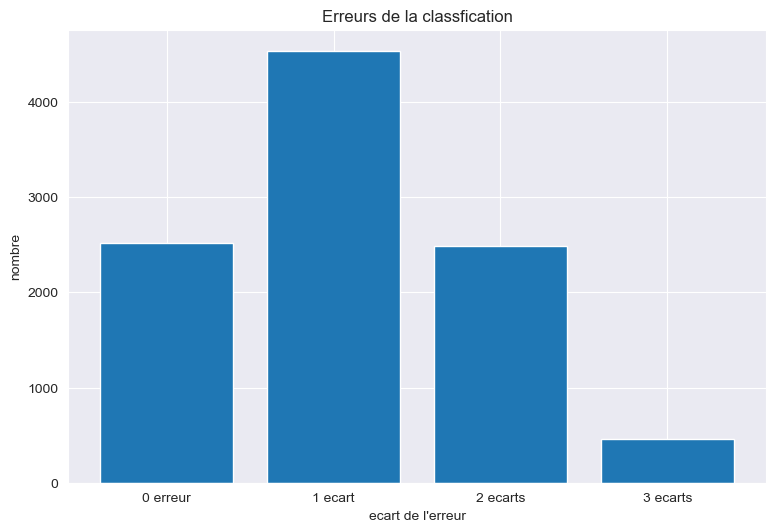

In [62]:
erreurs_transcribe = {"0 erreur":erreurs[0],"1 ecart" : erreurs[1],"2 ecarts" : erreurs[2],"3 ecarts" : erreurs[3] }
#style du plot
sns.set_style('darkgrid')
#taille des lables
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
#taille de la figure
plt.figure(figsize=(9,6), dpi = 100)
plt.bar(erreurs_transcribe.keys(), erreurs_transcribe.values())
plt.title('Erreurs de la classfication')
plt.xlabel("ecart de l'erreur")
plt.ylabel("nombre")